### Task 2 – Bayesian Change Point Detection on Brent Crude Oil Prices (2012–2022 focus)
**Objective**  
Identify structural breaks (mean shifts) using a single change-point Bayesian model in PyMC, quantify impacts, and associate detected breaks with major geopolitical/OPEC events.

In [ ]:
# ── Cell 1: Imports ────────────────────────────────────────────────────────────
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from statsmodels.tsa.stattools import adfuller

from src.data_preprocessor import BrentDataPreprocessor

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

In [5]:
# ── Cell 2: Load & prepare data (2012+) ────────────────────────────────────────
preprocessor = BrentDataPreprocessor()
df_full = preprocessor.add_features(focus_period=None)
df = preprocessor.get_processed(focus_period='2012-01-01')

prices = df['Price'].values
dates  = df.index
N      = len(prices)

print(f"Period: {dates.min():%Y-%m-%d} → {dates.max():%Y-%m-%d}")
print(f"Number of observations: {N:,}")
print(f"Shape check → prices: {prices.shape}, dates: {dates.shape}")

df.head(5)

Raw data loaded: 9011 rows, 2 columns
Data loaded successfully: 1987-05-20 to 2022-11-14
Total observations: 9011
Subset to 2012-01-01: 2760 observations
Period: 2012-01-03 → 2022-11-14
Number of observations: 2,760
Shape check → prices: (2760,), dates: (2760,)


,Price,log_price,log_return,rolling_vol_30d
Date,,,,
2012-01-03,111.12,4.710611,0.027646,0.249638
2012-01-04,113.37,4.730657,0.020046,0.245764
2012-01-05,113.59,4.732595,0.001939,0.241938
2012-01-06,111.96,4.718142,-0.014454,0.240186
2012-01-09,111.07,4.710161,-0.007981,0.237517


In [6]:
# 3: Basic stats
df['Price'].describe()

count    2760.000000
mean       74.144877
std        26.669376
min         9.120000
25%        52.272500
50%        67.560000
75%       103.122500
max       133.180000
Name: Price, dtype: float64

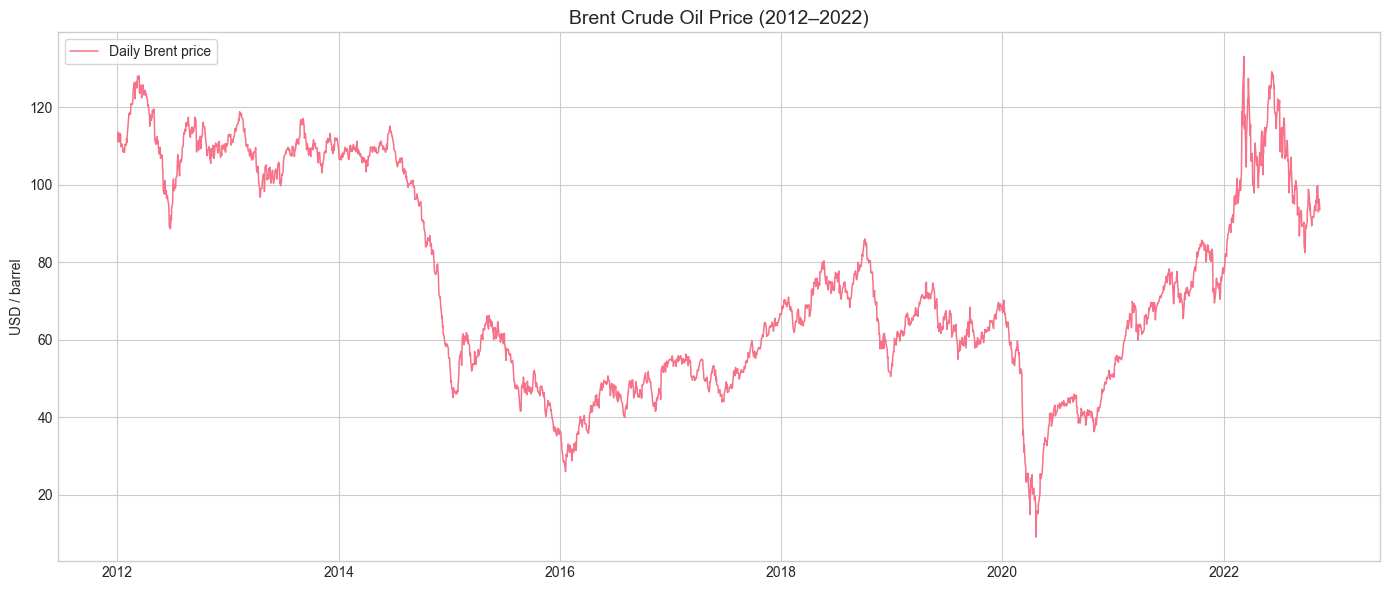

In [14]:
# ── Cell 3: Raw price series ───────────────────────────────────────────────────
plt.figure(figsize=(14, 6))
plt.plot(dates, df['Price'], lw=1.1, label='Daily Brent price')
plt.title('Brent Crude Oil Price (2012–2022)', fontsize=14)
plt.ylabel('USD / barrel')
plt.legend(loc='upper left', frameon=True)
plt.tight_layout()
plt.show()

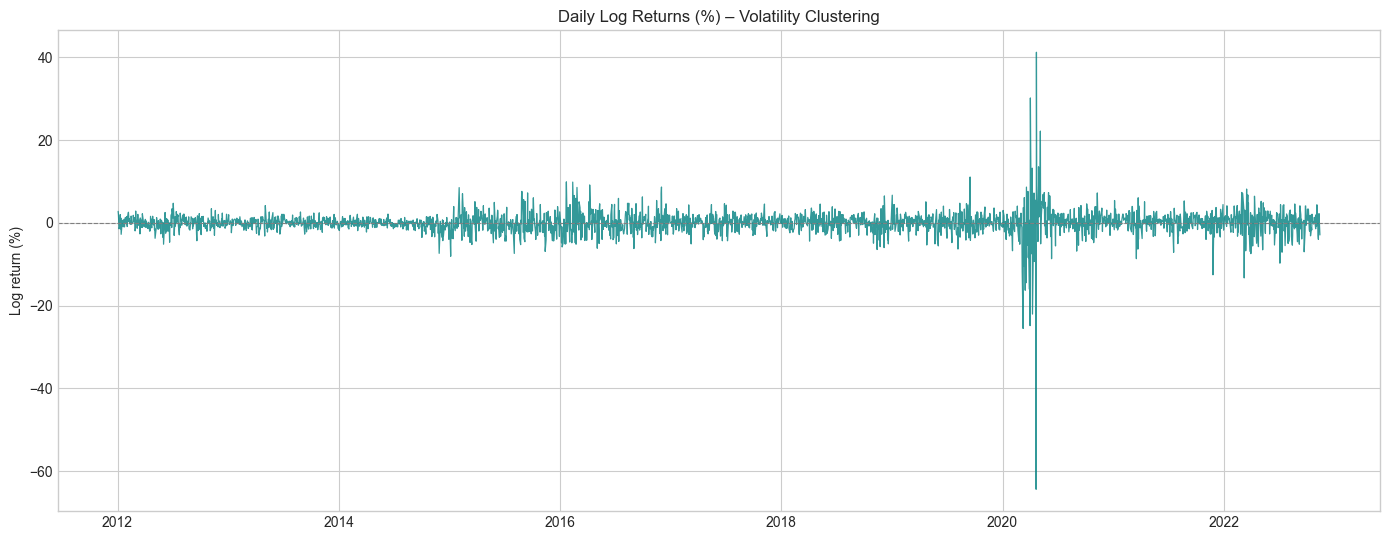

In [16]:
# ── Cell 4: Log returns – correct length alignment ─────────────────────────────
# Remove NaN and align dates in one step
log_ret_clean = df['log_return'].dropna()
dates_log     = df.index[-len(log_ret_clean):]   # take last N non-NaN dates

plt.figure(figsize=(14, 5.5))
plt.plot(dates_log, log_ret_clean * 100, 
         lw=0.9, color='teal', alpha=0.8)
plt.axhline(0, color='grey', lw=0.8, ls='--')
plt.title('Daily Log Returns (%) – Volatility Clustering')
plt.ylabel('Log return (%)')
plt.tight_layout()
plt.show()

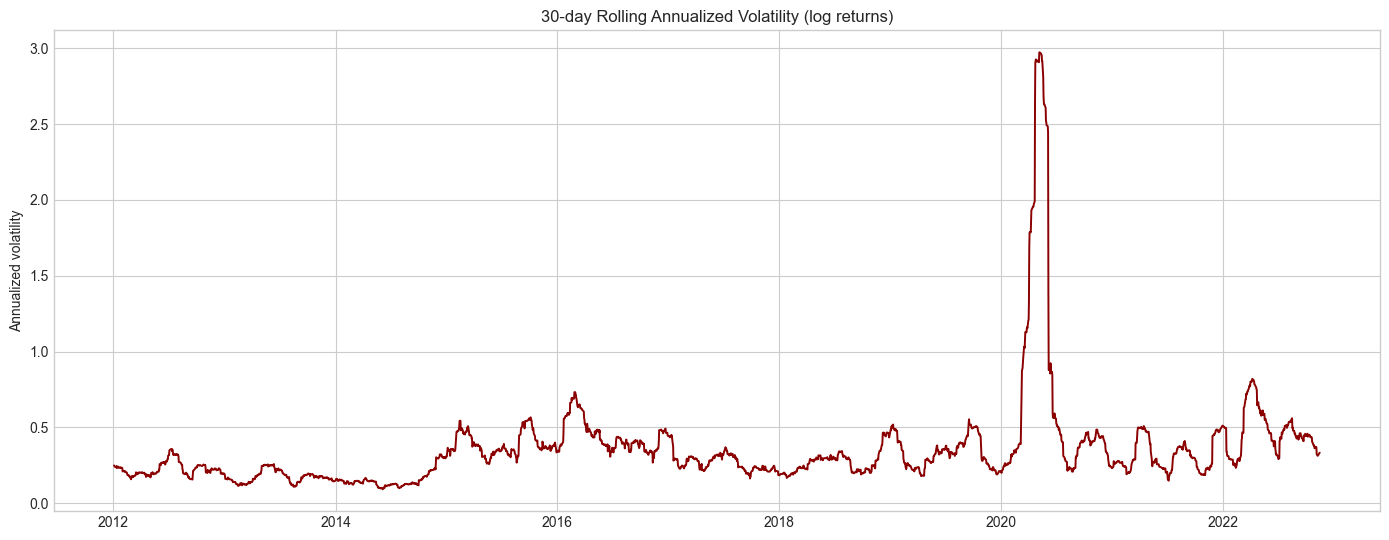

In [17]:
# ── Cell 5: Rolling volatility (correct alignment) ─────────────────────────────
vol = df['rolling_vol_30d'].dropna()              # removes first 29 NaNs
dates_vol = df.index[-len(vol):]                  # align from the end

plt.figure(figsize=(14, 5.5))
plt.plot(dates_vol, vol, color='darkred', lw=1.4)
plt.title('30-day Rolling Annualized Volatility (log returns)')
plt.ylabel('Annualized volatility')
plt.tight_layout()
plt.show()

In [23]:
# ── Stationarity test (ADF) ────────────────────────────────────────────────
def adf_report(series, title):
    """
    Run Augmented Dickey-Fuller test and print readable summary
    """
    res = adfuller(series.dropna(), autolag='AIC')
    print(f"\n{title}")
    print(f"  ADF statistic     : {res[0]:.4f}")
    print(f"  p-value           : {res[1]:.6f}")
    print(f"  Stationary?       : {'YES' if res[1] < 0.05 else 'NO'}")
    print(f"  Critical values   : {res[4]}")

# Run tests
adf_report(df['Price'],       "Price level (2012–2022)")
adf_report(df['log_price'],   "Log price level")
adf_report(df['log_return'],  "Daily log returns")

NameError: name 'adfuller' is not defined